# Image classification

## Import packages

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, GlobalAveragePooling2D, MaxPool2D, Dropout, Flatten, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorboard.plugins.hparams import api as hp
# from tensorflow.keras import optimizers

import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path, PureWindowsPath
from datetime import datetime    # per calcolare tempi di esecuzione

## Load data

In [2]:
start_time = datetime.now()

# SET DIR DATASET AND IMAGE TRAIN DIR
import sys

if sys.platform.startswith('linux'):
    DataSet = '/run/media/gianfranco/Data_SSD/'     
    PathImg = 'DATAset/RENE/Img/' 
elif sys.platform.startswith('win'):
    DataSet = 'E:\\'     
    PathImg = 'DATAset\\RENE\\Img\\' 
else:
    print('altro S. O.')
    
# DIR CON LE IMAMGINI DI TRAIN
train_dir = DataSet + PathImg

NET = 'VGG16'      # or 'VGG16' ; 'AlexNet'
SETname = 'rene'    # or 'Intel' ; 'coco-animals' ; 'VOC2012'

PATH_log = os.path.join(DataSet, 'Logs', NET, SETname)

if not os.path.exists(PATH_log):
            os.makedirs(PATH_log)
        
dateTime = datetime.now().strftime("%Y%m%d-%H%M%S")
        
LogsDir = os.path.join(PATH_log, dateTime)

print('PATh log = ', PATH_log)
print('LogsDir = ', LogsDir)
print(os.path.dirname(PATH_log))

PATh log =  E:\Logs\VGG16\rene
LogsDir =  E:\Logs\VGG16\rene\20210921-100211
E:\Logs\VGG16


The dataset has the following directory structure:

<pre>
<b>RENE/Img</b>
|__ <b>sclerosed</b>
    |______ <b>PNG images</b>
  
|__ <b>normal</b>
    |______ <b>PNG images</b>
</pre>

### Understand the data

In [3]:
total_train = 0

classNames = [x for x in os.listdir( train_dir )]  
print(classNames)

for x in classNames:
    if x != '.DS_Store':
        filePath = os.path.join(train_dir, x)
        num_x_train = len(os.listdir(filePath))
        total_train += num_x_train    #sommo le varie classi
        print('total training %s images: %d' % (x, num_x_train))

print("----------")
print("Total training images:", total_train)

['normal', 'sclerosed']
total training normal images: 1170
total training sclerosed images: 1170
----------
Total training images: 2340


#### COSTANTI
For convenience, set up variables to use while pre-processing the dataset and training the network.

In [4]:
batch_size = 8
epochs = 200
IMG_HEIGHT = 224
IMG_WIDTH = 224
classes = len(classNames)

# Regolarizzazione
L1 = 0.0001
L2 = 0.001

# Ottimizzazione
Adam = tf.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False, name='Adam')
RMSprop = tf.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')
SGD = tf.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True, name='SGD')

# scelta OPT
opt=Adam

## Data preparation

In [5]:
train_image_generator = ImageDataGenerator(
                                            rescale=1./(255),
                                            validation_split=0.2
                                          )

After defining the generators for training and validation images, the `flow_from_directory` method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [6]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           subset='training')
class_dict = train_data_gen.class_indices

print('Batches train=%d' % (len(train_data_gen)))

batchX, batchy = train_data_gen.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

print('sample max = ', np.max(train_data_gen[1][0][0][:,:,2]))
print('sample min = ', np.min(train_data_gen[1][0][0][:,:,2]))

Found 1872 images belonging to 2 classes.
Batches train=234
Batch shape=(8, 224, 224, 3), min=0.000, max=1.000
sample max =  1.0
sample min =  0.023529414


In [7]:
val_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=train_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical',
                                                              subset='validation')


Found 468 images belonging to 2 classes.


### Visualize training images

In [8]:
sample_training_images, labels = next(train_data_gen)

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

In [9]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr, labels):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax, label in zip( images_arr, axes, labels):
        ax.imshow(img)
        ax.axis('on')
        title = list(class_dict.keys())[list(class_dict.values()).index(np.argmax(label))]
        ax.set_title(title)
    plt.tight_layout()
    plt.show()

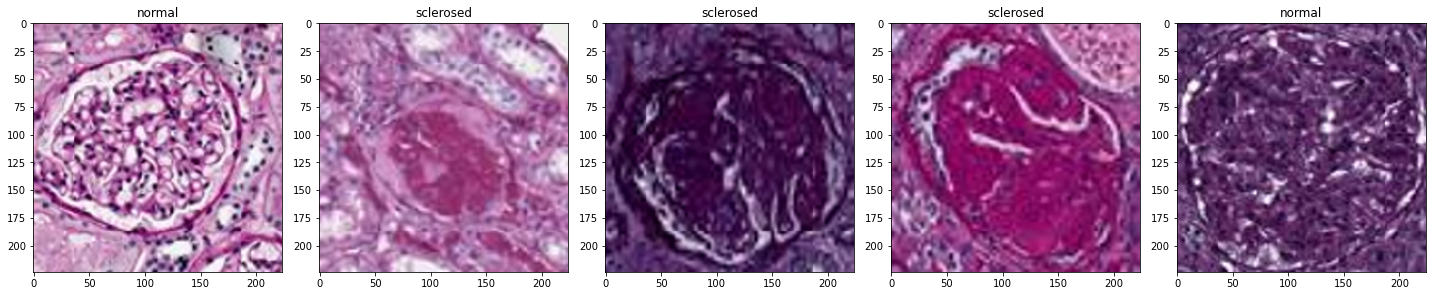

In [10]:
plotImages(sample_training_images[:5], labels[:5])

### Create "Callbacks" for Tensorboard monitor 

In [11]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 8, mode='max'),
    tf.keras.callbacks.ModelCheckpoint(filepath =os.path.join(PATH_log, 'Rene_'+dateTime+'_model.h5'), monitor = 'val_accuracy', save_best_only = True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.05, patience = 3, verbose=1, mode='max'),
    tf.keras.callbacks.TensorBoard(log_dir = LogsDir, histogram_freq = 1, embeddings_freq = 1)
]

#### REGOLARIZZAZIONE

In [12]:
reg = tf.keras.regularizers.L1L2(l1=L1, l2=L2)
reg.__dict__

{'l1': array(1.e-04, dtype=float32), 'l2': array(0.001, dtype=float32)}

## Create the model

The model consists of ... Alexnet

In [13]:
# AlexNet model

model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11), strides=(4,4), padding='valid', 
                 activation='relu', kernel_regularizer=reg, name = 'conv1'))
# Max Pooling
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid', name = 'pool1'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', 
                 activation='relu', kernel_regularizer=reg, name = 'conv2'))
# Max Pooling
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid', name ='pool2'))

# 3rd Convolutional Layer
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', 
                 activation='relu', kernel_regularizer=reg, name = 'conv3'))

# 4th Convolutional Layer
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', 
                 activation= 'relu', kernel_regularizer=reg, name = 'conv4'))

# 5th Convolutional Layer
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid', 
                 activation= 'relu', kernel_regularizer=reg, name = 'conv5'))
# Max Pooling
#model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name = 'pool5'))

# ADD layers Zhou
'''model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='valid', 
                 activation="relu", kernel_regularizer=reg, name = 'conv6'))'''

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding="valid", 
                 activation="relu", kernel_regularizer=reg, name = 'conv6'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding="valid", 
                 activation="relu", kernel_regularizer=reg, name = 'conv7'))
model.add(GlobalAveragePooling2D(name = 'GAP'))
model.add(Dense(units=len(class_dict), activation="softmax"))

### Compile the model

For this tutorial, choose the *ADAM* optimizer and *binary cross entropy* loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [14]:
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Adam.__dict__

{'_use_locking': True,
 '_name': 'Adam',
 '_hyper': {'learning_rate': 1e-05,
  'decay': 0.0,
  'beta_1': 0.9,
  'beta_2': 0.999},
 '_slots': {},
 '_slot_names': [],
 '_weights': [],
 '_iterations': None,
 '_deferred_slot_restorations': {},
 '_initial_decay': 0.0,
 '_hypers_created': False,
 'epsilon': 1e-08,
 'amsgrad': False,
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [],
 '_self_unconditional_dependency_names': {},
 '_self_unconditional_deferred_dependencies': {},
 '_self_update_uid': -1,
 '_self_name_based_restores': set()}

### Model summary

View all the layers of the network using the model's `summary` method:

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 55, 55, 96)        34944     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 27, 27, 96)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 27, 27, 256)       614656    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 13, 13, 256)       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 15, 15, 256)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 13, 13, 384)       885120    
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 15, 15, 384)       0

### Train the model

Use the 'fit' (`fit_generator`) method of the `ImageDataGenerator` class to train the network.

In [16]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=epochs,
    callbacks = callbacks_list,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size
)
for key in history.history:
    print(key)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 234 steps, validate for 58 steps
Epoch 1/200
233/234 [============================>.] - ETA: 0s - loss: 12.0594 - accuracy: 0.6368
Epoch 00001: val_accuracy improved from -inf to 0.87931, saving model to E:\Logs\VGG16\rene\Rene_20210921-100211_model.h5
234/234 [==============================] - 64s 275ms/step - loss: 12.0550 - accuracy: 0.6373 - val_loss: 10.9899 - val_accuracy: 0.8793
Epoch 2/200
233/234 [============================>.] - ETA: 0s - loss: 10.3207 - accuracy: 0.9008
Epoch 00002: val_accuracy improved from 0.87931 to 0.91595, saving model to E:\Logs\VGG16\rene\Rene_20210921-100211_model.h5
234/234 [==============================] - 56s 240ms/step - loss: 10.3181 - accuracy: 0.9012 - val_loss: 9.6747 - val_accuracy: 0.9159
Epoch 3/200
233/234 [============================>.] - ETA: 0s - loss: 9.1628 - accuracy: 0.9061
Epoch 00003: val_accuracy did not improve from 0.91595
234/234 [==============================] 

### Visualize training results

Now visualize the results after training the network.

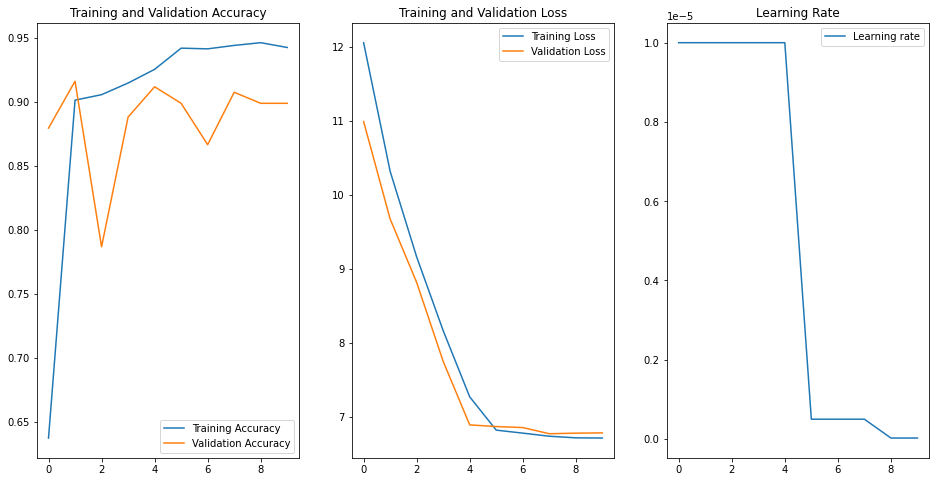

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

lr=history.history['lr']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, lr, label='Learning rate')
plt.legend(loc='upper right')
plt.title('Learning Rate')
plt.show()

In [18]:
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:09:36.446566


## Overfitting

In [19]:
# restart kernel to reinitialize variables
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

## Data augmentation

In [20]:
start_time2 = datetime.now()
dateTime = datetime.now().strftime("%Y%m%d-%H%M%S")

LogsDir = os.path.join(PATH_log, datetime.now().strftime("%Y%m%d-%H%M%S")) 

callbacks_list_2 = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 7),
    tf.keras.callbacks.ModelCheckpoint(filepath =os.path.join(PATH_log, 'Rene2_'+dateTime+'_model_2.h5'), monitor = 'val_accuracy', save_best_only = True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.05, patience = 2, verbose=1, mode='max'),
    tf.keras.callbacks.TensorBoard(log_dir = LogsDir, histogram_freq = 1, embeddings_freq = 1)
]

#### COSTANTI

In [21]:
L1 = 0.00001
L2 = 0.001

Adam = tf.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False, name='Adam')
RMSprop = tf.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')
SGD = tf.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True, name='SGD')

opt = Adam

### Augment and visualize data

In [22]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    #preprocessing_function = std_setVoc,
                    rotation_range=45,
                    #width_shift_range=.15,
                    #height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5,
                    brightness_range=[0.6, 1.0],
                    validation_split=0.2
                    )

In [23]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical',
                                                     subset='training')

Found 1872 images belonging to 2 classes.


Visualize how a single image would look five different times when passing these augmentations randomly to the dataset.

### Create validation data generator

Generally, only apply data augmentation to the training examples. In this case, only rescale the validation images and convert them into batches using `ImageDataGenerator`.

In [24]:
# image_gen_val = ImageDataGenerator(rescale=1./255)

In [25]:
val_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                 directory=train_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='categorical',
                                                 subset='validation')

Found 468 images belonging to 2 classes.


#### REGOLARIZZAZIONE

In [26]:
import tensorflow as tf
reg = tf.keras.regularizers.L1L2(l1=L1, l2=L2)

reg.__dict__

{'l1': array(1.e-05, dtype=float32), 'l2': array(0.001, dtype=float32)}

## Dropout

## Creating a new network with Dropouts

In [27]:
model_new = Sequential()

# 1st Convolutional Layer
model_new.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu', input_shape=(224,224,3), kernel_regularizer=reg))

# Add Dropout to prevent overfitting
# model_new.add(Dropout(0.2))

# Max Pooling 1
model_new.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
model_new.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', kernel_regularizer=reg))

# Add Dropout to prevent overfitting
# model_new.add(Dropout(0.3))

# Max Pooling 2
model_new.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same'))

# 3rd Convolutional Layer
model_new.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=reg))

# Add Dropout to prevent overfitting
# model_new.add(Dropout(0.35))


# 4th Convolutional Layer
model_new.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=reg))

# Add Dropout to prevent overfitting
model_new.add(Dropout(0.35))

# 5th Convolutional Layer
model_new.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=reg))

# Add Dropout to prevent overfitting
model_new.add(Dropout(0.3))

# ADD layers Zhou
model_new.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='valid', activation="relu", kernel_regularizer=reg))

# Add Dropout to prevent overfitting
model_new.add(Dropout(0.4))

model_new.add(Conv2D(filters=1024, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu", kernel_regularizer=reg))

# Add Dropout to prevent overfitting
model_new.add(Dropout(0.5))

model_new.add(GlobalAveragePooling2D())
model_new.add(Dense(units=len(class_dict), activation="softmax"))

In [28]:
model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 384)       1327488   
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 384)      

### Compile the model

After introducing dropouts to the network, compile the model and view the layers summary.

In [29]:
model_new.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Adam.__dict__

{'_use_locking': True,
 '_name': 'Adam',
 '_hyper': {'learning_rate': 1e-05,
  'decay': 0.0,
  'beta_1': 0.9,
  'beta_2': 0.999},
 '_slots': {},
 '_slot_names': [],
 '_weights': [],
 '_iterations': None,
 '_deferred_slot_restorations': {},
 '_initial_decay': 0.0,
 '_hypers_created': False,
 'epsilon': 1e-08,
 'amsgrad': False,
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [],
 '_self_unconditional_dependency_names': {},
 '_self_unconditional_deferred_dependencies': {},
 '_self_update_uid': -1,
 '_self_name_based_restores': set()}

### Train the model

After successfully introducing data augmentations to the training examples and adding dropouts to the network, train this new network:

In [30]:
history = model_new.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=epochs,
    callbacks = callbacks_list_2,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 234 steps, validate for 58 steps
Epoch 1/200
233/234 [============================>.] - ETA: 0s - loss: 3.7114 - accuracy: 0.6212
Epoch 00001: val_accuracy improved from -inf to 0.81466, saving model to E:\Logs\VGG16\rene\Rene2_20210921-101148_model_2.h5
234/234 [==============================] - 79s 336ms/step - loss: 3.7086 - accuracy: 0.6229 - val_loss: 3.3118 - val_accuracy: 0.8147
Epoch 2/200
233/234 [============================>.] - ETA: 0s - loss: 3.0808 - accuracy: 0.8766
Epoch 00002: val_accuracy did not improve from 0.81466
234/234 [==============================] - 73s 311ms/step - loss: 3.0795 - accuracy: 0.8766 - val_loss: 3.0699 - val_accuracy: 0.8039
Epoch 3/200
233/234 [============================>.] - ETA: 0s - loss: 2.7832 - accuracy: 0.8868
Epoch 00003: val_accuracy improved from 0.81466 to 0.85776, saving model to E:\Logs\VGG16\rene\Rene2_20210921-101148_model_2.h5
234/234 [==============================]

### Visualize the model

Visualize the new model after training, you can see that there is significantly less overfitting than before. The accuracy should go up after training the model for more epochs.

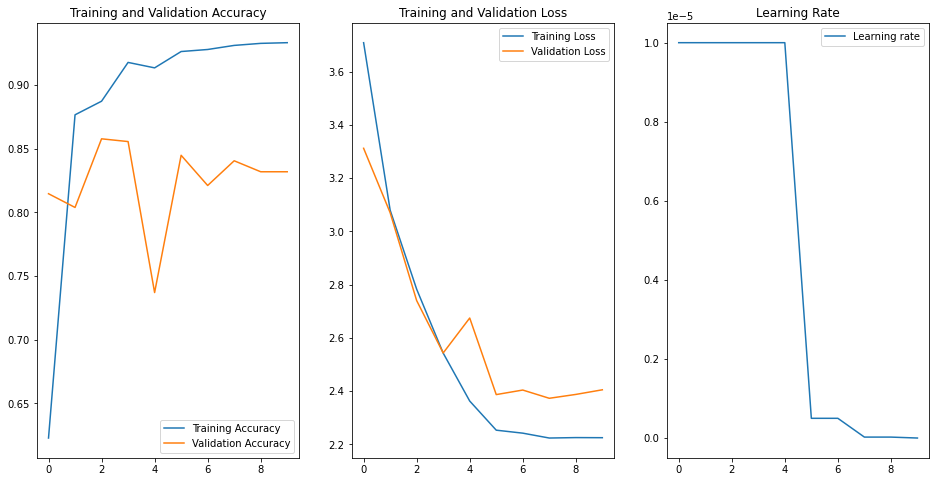

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

lr=history.history['lr']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, lr, label='Learning rate')
plt.legend(loc='upper right')
plt.title('Learning Rate')
plt.show()

In [32]:
end_time2 = datetime.now()
print('Duration: {}'.format(end_time2 - start_time2))

Duration: 0:12:15.773906
